# Chapter 9: The Size Effect

## Introduction
- Definition: stocks with large market capitalizations (large stocks) tend to have lower returns than stocks with small market capitalizations (small stocks).
- Based on the size effect, Fama & French created a portfolio, whose return is known as SMB factor  

## Objective
1. the calculation of market capitalization
2. its ability to predict future stock returns
3. examine the properties of the SMB

## 9.1 Calculating Market Capitalization
total value of the out-standing stock shares = total number of equity shares * the price of one share    

#### Two calculation approaches:
1. calculate capitalization using data from last trading day during the given month (most recent data available)
2. FF calculate capitalization on last trading day of June, and hold the value from June until next May

#### Adjustments:
- MktCap is highly skewed ➡ Size = ln(MktCap)
- Inflation ➡ adjust the measure using CPI    
    - MktCap_CPI = MktCap * (CPI_T / CPI_t)
    - Size_CPI = ln(MktCap_CPI)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.ticker as mtick
from scipy.stats.mstats import winsorize

# Calculate MktCap
# 直接导入流通市值 
data = pd.read_csv('monthly.csv').iloc[:,:-1]
data.mktcap /= 1000  # calculate in millions

# 构造mktcap_ff
data = data.join(data.date.str.split('-',expand = True))
junedata = data[data.iloc[:,-1]=='06']
junedata['mktcap_ff'] = junedata.mktcap
data = data.join(junedata.mktcap_ff)
data = data[['code','date','rt','mktcap','mktcap_ff']]
for i in data.code.unique():
    s = data[data.code == i].index[0]
    e = data[data.code == i].index[-1]
    data.iloc[s:e+1,4] = data[data.code == i].mktcap_ff.fillna(method = 'ffill')
    
# 构造mktcap_cpi
cpi = pd.read_excel('CPI环比.xlsx')
cpi.infl = cpi.infl/100 +1
cpi['cpi'] = cpi.infl.cumprod() # 把环比通货膨胀率累乘转化为的指数
cpi.columns = ['date','infl','cpi']
data = data.merge(cpi,on = 'date',how = 'left')

cpi1912 = cpi[cpi.date == '2019-12'].cpi.values

data['mktcap_cpi'] = data.mktcap * cpi1912 / data.cpi
data['mktcap_ffcpi'] = data.mktcap_ff * cpi1912 / data.cpi

# 构造mktcap mktcap_ff mktcap_cpi 对应的size
data['size'] = np.log(data.mktcap)
data['size_ff'] = np.log(data.mktcap_ff)
data['size_cpi'] = np.log(data.mktcap_cpi)
data['size_ffcpi'] = np.log(data.mktcap_ffcpi)

data = data.drop(columns = ['infl','cpi'])
data = data.dropna()

D:\Users\longzhen\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [2]:
data.head()

,code,date,rt,mktcap,mktcap_ff,mktcap_cpi,mktcap_ffcpi,size,size_ff,size_cpi,size_ffcpi
5,1,1997-06,0.121879,26943.90630,26943.9063,42088.251684,42088.251684,10.201512,10.201512,10.647524,10.647524
6,1,1997-07,-0.080816,24766.40459,26943.9063,39156.723566,42599.445024,10.117243,10.201512,10.575327,10.659597
7,1,1997-08,-0.036033,23731.19887,26943.9063,37296.242484,42345.372787,10.074546,10.201512,10.526648,10.653614
8,1,1997-09,-0.038357,22820.93176,26943.9063,35266.131325,41637.534698,10.035433,10.201512,10.470678,10.636757
9,1,1997-10,0.177382,26868.94312,26943.9063,41772.324939,41888.867905,10.198726,10.201512,10.639989,10.642775


## 9.2 Summary Statistics

In [4]:
# 构造table1
table1 = pd.DataFrame(index = ['mktcap','size', 'mktcap_cpi','size_cpi',
                               'mktcap_ff','size_ff', 'mktcap_ffcpi','size_ffcpi'],
    columns = ['mean','SD','skew','kurt','min','5%','25%','median',
               '75%','95%','max','n'])
def month_sum(s): 
    # 得到每期的数据值
    me,SD,sk,ku = s.mean(),s.std(),s.skew(),s.kurt()
    mi,ma = s.min(),s.max()
    p5,p25,p50,p75,p95 = np.percentile(s,[5,25,50,75,95])
    n = len(s)
    return me,SD,sk,ku,mi,p5,p25,p50,p75,p95,ma,n
def mean_sum(var):
    # 得到数据值时间序列
    vardata = data[['date',var]]
    ts = pd.DataFrame(index = vardata.date.unique(),columns = ['mean','SD','skew',
                      'kurt','min','5%','25%','median','75%','95%','max','n'])
    for t in ts.index:
        ts.loc[t] = month_sum(vardata[vardata.date == t][var])
    return ts

for i in range(len(table1)):
    a = mean_sum(table1.index[i])
    a = a.sort_index().iloc[31:,:] # 从2000.1开始
    table1.iloc[i,:] = a.mean()
del a,i

In [34]:
table1.applymap(lambda x:round(x, 2))

,mean,SD,skew,kurt,min,5%,25%,median,75%,95%,max,n
mktcap,6327.58,27265.23,13.93,299.63,33.22,504.67,1346.19,2358.30,4600.50,17497.37,784248.15,2013.05
size,7.51,1.08,0.08,2.07,3.33,5.86,6.91,7.46,8.10,9.31,12.42,2013.05
mktcap_cpi,7389.34,31326.26,13.93,299.63,41.50,596.83,1607.74,2806.19,5446.42,20450.04,897333.22,2013.05
size_cpi,7.78,1.08,0.08,2.07,3.60,6.13,7.17,7.72,8.36,9.57,12.68,2013.05
mktcap_ff,5856.29,24732.81,13.65,292.63,31.56,447.58,1233.25,2214.66,4343.93,16507.26,712194.29,2013.05
size_ff,7.45,1.08,0.05,2.00,3.28,5.78,6.84,7.40,8.04,9.25,12.29,2013.05
mktcap_ffcpi,6812.48,28182.34,13.65,292.63,39.72,531.58,1475.99,2632.27,5125.36,19241.12,806976.50,2013.05
size_ffcpi,7.71,1.08,0.05,2.00,3.54,6.04,7.10,7.66,8.30,9.52,12.55,2013.05


table 9.1 Summary Statistics

![微信截图_20200417134111.png](https://i.loli.net/2020/04/17/t97M4UDJ1HV56Ok.png)

- MktCap highly skewed
- Size is much less skewed
- With the exception of skewness and excess kurtosis, is larger for MktCap_CPI than for MktCap
- FF variables are similar enough to the first approach

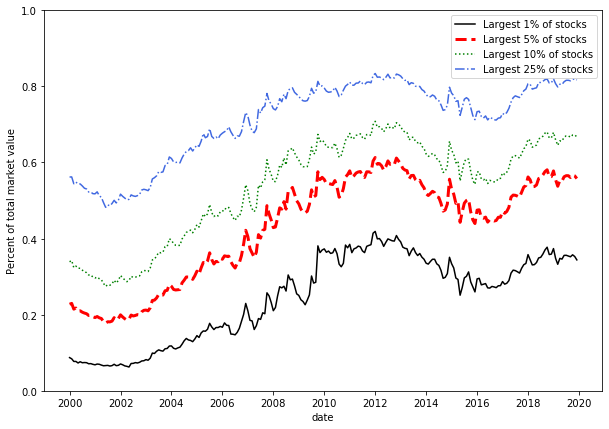

In [7]:
# figure 1
vardata = data[['date','mktcap']]

ts = pd.DataFrame(index = vardata.date.unique(),columns = ['t1','t5','t10','t25']).sort_index()
def topcap(subdata):
    # 计算每一期前1% 5% 10% 25%大市值股票占全市场市值比重
    n = len(subdata)
    sub = subdata.sort_values(ascending = False).cumsum()
    top1 = sub.iloc[int(n/100)]/sub.iloc[-1]
    top5 = sub.iloc[int(n/20)]/sub.iloc[-1]
    top10= sub.iloc[int(n/10)]/sub.iloc[-1]
    top25= sub.iloc[int(n/4)]/sub.iloc[-1]
    return top1,top5,top10,top25

for t in ts.index:
    subdata = vardata[vardata.date == t]['mktcap']
    ts.loc[t] = topcap(subdata)

ts = ts.iloc[31:,:]

plt.figure(figsize=(10,7))
plt.plot(ts.t1, c='k', ls='-',label='Largest 1% of stocks')
plt.plot(ts.t5, c='r', ls='--', lw=3,label='Largest 5% of stocks')
plt.plot(ts.t10, c='g', ls=':',label='Largest 10% of stocks')
plt.plot(ts.t25, c='royalblue', ls='-.',label='Largest 25% of stocks')
plt.xticks(range(0,241,24),range(2000,2021,2))
plt.xlabel('date')
plt.ylabel('Percent of total market value')
plt.ylim(0,1)
plt.legend()
plt.show()

![Markdown](http://i2.tiimg.com/716668/a68546f3ee47662c.png)

## 9.3 Correlations

In [8]:
# table 2
beta = pd.read_csv('beta.csv',index_col = 0).iloc[:,25:]
beta.columns = ts.index

def corr(t):
    # 计算得到t期的两种相关系数矩阵
    bdata = pd.DataFrame(beta[t])
    bdata['code'] = bdata.index
    bdata['date'] = t
    bdata.columns = ['beta','code','date']
    bdata = bdata.dropna()
    bdata = pd.merge(bdata,data,on= ['code','date'],how = 'left')
    bdata = bdata[['mktcap','size','mktcap_ff','size_ff','beta']]
    a = bdata.corr('pearson')
    b = bdata.corr('spearman')
    return a,b
prs,sprm = corr(beta.columns[0])
for t in beta.columns[1:]:
    a,b = corr(t)
    prs += a
    sprm += b
prs /= 240
sprm /= 240 # 得到240期的均值

table2 = prs
for i in range(5): # 将两种相关系数整合到table2
    for j in range(5):
        if i == j:
            table2.iloc[i,j] = np.nan
        if i < j:
            table2.iloc[i,j] = sprm.iloc[i,j] 

In [35]:
table2.applymap(lambda x:round(x, 2))

,mktcap,size,mktcap_ff,size_ff,beta
mktcap,NaN,1.00,0.95,0.95,-0.14
size,0.61,NaN,0.95,0.95,-0.14
mktcap_ff,0.94,0.60,NaN,1.00,-0.12
size_ff,0.59,0.96,0.62,NaN,-0.12
beta,-0.18,-0.18,-0.18,-0.17,NaN


![Markdown](http://i2.tiimg.com/716668/5fb467daca3fd75a.png)

- The only difference is MktCaps' correlations with beta.

## 9.4 Persistence

In [10]:
def pst():
    for lag in [1,3,6,12,24,36,48,60,120]:
        lagts = pd.DataFrame(index = range(lag,len(ts)),columns = ['cap','size','cap_ff','size_ff'])
        for i in range(lag,len(ts.index)):
            t = ts.index[i]
            pdata = data[data.date == t][['code','mktcap','size','mktcap_ff','size_ff']]
            lagdata = data[data.date == ts.index[i-lag]][['code','mktcap','size',
                                                          'mktcap_ff','size_ff']]
            lagdata.columns = ['code','caplag','sizelag','capfflag','sizefflag']
            pldata = pd.merge(pdata,lagdata,on=['code'],how='inner')
            lagts.loc[i][0] = np.corrcoef(pldata.mktcap,pldata.caplag)[0][1]
            lagts.loc[i][1] = np.corrcoef(pldata['size'],pldata.sizelag)[0][1]
            lagts.loc[i][2] = np.corrcoef(pldata.mktcap_ff,pldata.capfflag)[0][1]
            lagts.loc[i][3] = np.corrcoef(pldata.size_ff,pldata.sizefflag)[0][1]
        table3.loc[lag] = lagts.mean()
table3 = pd.DataFrame(index = [1,3,6,12,24,36,48,60,120],
                      columns = ['cap','size','cap_ff','size_ff'])
pst()            

In [36]:
table3.applymap(lambda x:round(x, 3))

,cap,size,cap_ff,size_ff
1,0.990,0.994,0.992,0.994
3,0.972,0.983,0.975,0.983
6,0.948,0.969,0.951,0.966
12,0.908,0.941,0.903,0.934
24,0.835,0.893,0.835,0.886
36,0.776,0.848,0.764,0.837
48,0.727,0.817,0.712,0.805
60,0.691,0.789,0.672,0.776
120,0.592,0.694,0.581,0.685


- Regardliess of how market capitalization is measured, it is highly persist.

![Markdown](http://i2.tiimg.com/716668/d8e9056e2e5bb33b.png)

## 9.5 Size and Stock Returns
### 9.5.1 Univariate Portfolio Analysis
- In US market, breakpoints are calculated using only NYSE stocks. Here we use full samples.

In [12]:
#%% table 4 panel A
def sort10(sdata):
    # data: DataFrame: code date mktcap mktcap_cpi
    sdata.columns = ['code','date','cap','capcpi']
    pA = pd.DataFrame(index = ['mktcap','mktcap_cpi','%mktcap','n','beta'],columns = range(1,11)).fillna(0)
    for t in ts.index:
        bdata = pd.DataFrame(beta[t])
        bdata['code'] = bdata.index
        bdata['date'] = t
        bdata.columns = ['beta','code','date']
        bdata = bdata.dropna()

        tdata = sdata[sdata.date==t]
        tdata = pd.merge(bdata,tdata,on= ['code','date'],how = 'inner')
        tdata = tdata.sort_values('cap').reset_index()
        
        tdata['deci'] = np.trunc(tdata.index/(len(tdata)/10))+1
        pA.loc['mktcap'] += tdata[['deci','cap']].groupby('deci').mean().T.values.tolist()[0]
        pA.loc['mktcap_cpi'] += tdata[['deci','capcpi']].groupby('deci').mean().T.values.tolist()[0]
        pA.loc['%mktcap'] += (tdata[['deci','cap']].groupby('deci').sum().T.values.tolist()[0])/tdata.cap.sum()*100
        pA.loc['n'] += tdata[['deci','cap']].groupby('deci').count().T.values.tolist()[0]
        pA.loc['beta'] += tdata[['deci','beta']].groupby('deci').mean().T.values.tolist()[0]
#        print(t)
    return pA/len(ts.index)

pA1 = sort10(data[['code','date','mktcap','mktcap_cpi']])
pA2 = sort10(data[['code','date','mktcap_ff','mktcap_ffcpi']])
pA2.index = ['mktcap_ff','mktcap_ffcpi','%mktcap_ff','n_ff','beta_ff']
table4pA = pA1.append(pA2)

In [37]:
table4pA.applymap(lambda x:round(x, 2))

,1,2,3,4,5,6,7,8,9,10
mktcap,729.06,1172.15,1520.78,1887.31,2329.29,2902.02,3736.02,5113.50,8200.16,43273.30
mktcap_cpi,877.84,1404.81,1818.02,2251.86,2774.27,3449.57,4430.86,6042.80,9633.74,49956.10
%mktcap,1.47,2.25,2.84,3.45,4.17,5.10,6.39,8.42,12.74,53.17
n,171.22,170.67,170.78,170.70,170.57,170.88,170.80,170.68,170.77,170.27
beta,1.12,1.13,1.12,1.12,1.11,1.11,1.09,1.08,1.06,0.96
mktcap_ff,664.24,1086.38,1433.61,1790.36,2210.28,2757.48,3552.39,4855.47,7700.49,39932.08
mktcap_ffcpi,803.38,1304.13,1713.01,2133.52,2627.75,3269.88,4200.39,5719.35,9019.29,45843.80
%mktcap_ff,1.49,2.29,2.90,3.53,4.26,5.20,6.50,8.56,12.86,52.41
n_ff,171.22,170.67,170.78,170.70,170.57,170.88,170.80,170.68,170.77,170.27
beta_ff,1.11,1.13,1.12,1.12,1.11,1.11,1.10,1.09,1.06,0.96


![Markdown](http://i1.fuimg.com/716668/e8984d2ff6e62468.png)

In [18]:
# table 4 panel B & C
def wmean(data):
    return np.average(data.rt,weights = data.cap)
def retts11(udata):
    # 得到11个组的超额收益率序列, 返回两个序列，分别是等权 & 市值加权
    # udata: DataFrame: code date ret mktcap 
    udata.columns = ['code','date','rt','cap']
    lcdata = pd.DataFrame(columns = ['code','date','rt','cap'])
    for i in udata.code.unique():
        subdata = udata[udata.code == i]
        subdata = subdata.sort_values('date')
        subdata.cap = subdata.cap.shift(1)
        lcdata = lcdata.append(subdata)
    retts1 = pd.DataFrame(index = ts.index,columns=range(1,11))
    retts2 = pd.DataFrame(index = ts.index,columns=range(1,11))
    
    for t in ts.index:
        tdata = lcdata[lcdata.date==t].dropna()
        tdata = tdata.sort_values('cap').reset_index()
        tdata['deci'] = np.trunc(tdata.index/(len(tdata)/10))+1
        retts1.loc[t] = tdata[['deci','cap','rt']].groupby('deci').mean().rt.T.values.tolist()
        retts2.loc[t] = tdata[['deci','cap','rt']].groupby('deci').agg(wmean).rt.T.values.tolist()
    retts1['10-1'] = retts1.iloc[:,9]-retts1.iloc[:,0]
    retts2['10-1'] = retts2.iloc[:,9]-retts2.iloc[:,0]
    return retts1,retts2
capts_ew,capts_vw = retts11(data[['code','date','rt','mktcap']])
capffts_ew,capffts_vw = retts11(data[['code','date','rt','mktcap_ff']])
        
factor5 = pd.read_csv('fivefactor_monthly.csv')
facdata = factor5[['mkt_rf','rf']].iloc[71:311,:]
for i in range(10):
    capts_ew.iloc[:,i] -= facdata.rf.tolist()
    capts_vw.iloc[:,i] -= facdata.rf.tolist()
    capffts_ew.iloc[:,i] -= facdata.rf.tolist()
    capffts_vw.iloc[:,i] -= facdata.rf.tolist()

def NWtest_1sample(a, lags=6):
    adj_a = np.array(a)
    # 对常数回归
    model = sm.OLS(adj_a, [1] * len(adj_a)).fit(cov_type='HAC', cov_kwds={'maxlags': lags})
    return adj_a.mean(), float(model.tvalues)

def portret(retts):
    # retts: DataFrame: 11列收益率
    # mkt: Series: 市场因子
    pBC = pd.DataFrame(index = ['ret','ret_t','alpha','alpha_t'],columns = capts_ew.columns)
    for i in range(11):
        pBC.iloc[0,i],pBC.iloc[1,i] = NWtest_1sample(retts.iloc[:,i].tolist())
        model = sm.OLS(retts.iloc[:,i].tolist(),sm.add_constant(facdata.mkt_rf))
        model = model.fit(cov_type='HAC',cov_kwds={'maxlags':6})
        pBC.iloc[2,i],pBC.iloc[3,i] = model.params[0],model.tvalues[0]
    return pBC
pB1,pB2 = portret(capts_ew),portret(capffts_ew)
pC1,pC2 = portret(capts_vw),portret(capffts_vw)
table4pBC = pB1.append([pB2,pC1,pC2])
table4pBC.index = ['ret_ew','ret_t_ew','alpha_ew','alpha_t_ew',
                   'retff_ew','retff_t_ew','alphaff_ew','alphaff_t_ew',
                   'ret_vw','ret_t_vw','alpha_vw','alpha_t_vw',
                   'retff_vw','retff_t_vw','alphaff_vw','alphaff_t_vw']

In [44]:
table4pBC.applymap(lambda x:round(x, 4))

,1,2,3,4,5,6,7,8,9,10,10-1
ret_ew,0.0300,0.0206,0.0176,0.0146,0.0109,0.0096,0.0090,0.0075,0.0073,0.0069,-0.0231
ret_t_ew,2.9580,2.3883,2.1145,1.8053,1.4153,1.2584,1.1945,1.0127,0.9818,0.9535,-3.2334
alpha_ew,0.0215,0.0119,0.0090,0.0060,0.0025,0.0012,0.0006,-0.0006,-0.0006,-0.0005,-0.0219
alpha_t_ew,3.5241,3.0571,2.8719,2.3032,1.0806,0.5944,0.3867,-0.4662,-0.6320,-0.3855,-3.1748
retff_ew,0.0276,0.0185,0.0161,0.0151,0.0122,0.0108,0.0093,0.0089,0.0084,0.0071,-0.0205
retff_t_ew,2.7378,2.1977,2.0111,1.8389,1.5832,1.4000,1.2502,1.1780,1.1288,0.9741,-2.9703
alphaff_ew,0.0192,0.0099,0.0077,0.0065,0.0037,0.0024,0.0010,0.0007,0.0003,-0.0002,-0.0194
alphaff_t_ew,3.1800,2.9349,2.5168,2.4560,1.6410,1.1479,0.5696,0.4955,0.3828,-0.2182,-2.9146
ret_vw,0.0272,0.0203,0.0175,0.0145,0.0109,0.0096,0.0089,0.0074,0.0073,0.0066,-0.0206
ret_t_vw,2.8363,2.3716,2.1085,1.7935,1.4121,1.2540,1.1927,1.0011,0.9834,0.9581,-2.9154


![Markdown](http://i1.fuimg.com/716668/557eb931a3b293c4.png)

![Markdown](http://i2.tiimg.com/716668/3b1bac83776758a0.png)

#### -The size effect in China is stronger than that in US. 

### 9.5.2 Bivariate Portfolio Analysis
*similar conclusions as univariate portfolio analysis

In [20]:
beta = pd.read_csv('beta.csv',index_col = 0).iloc[:,-241:]
beta.columns = ['1999-12'] + ts.index.tolist()

def wmean2(data):
    return np.average(data.rt,weights = data.mktcap)

def portts25():
    fdata = pd.DataFrame() 
    for t in beta.columns:
        bdata = pd.DataFrame(beta[t])
        bdata['code'] = bdata.index
        bdata['date'] = t
        bdata.columns = ['beta','code','date']
        bdata = bdata.dropna()
        subdata = bdata.merge(data[['code','date','mktcap','rt']],on=['code','date'],
                              how = 'inner')
        fdata = fdata.append(subdata)
    lcdata = pd.DataFrame()  
    for i in fdata.code.unique():
        subdata = fdata[fdata.code == i]
        subdata = subdata.sort_values('date')
        subdata.mktcap = subdata.mktcap.shift(1)
        subdata.beta = subdata.beta.shift(1)
        lcdata = lcdata.append(subdata)
    grdata = pd.DataFrame()
    for t in ts.index:
        tdata = lcdata[lcdata.date==t].dropna()
        tdata = tdata.sort_values('beta').reset_index(drop = True)
        tdata['deci1'] = np.trunc(tdata.index/(len(tdata)/5))+1
        tdata = tdata.sort_values('mktcap').reset_index(drop = True)
        tdata['deci2ind'] = np.trunc(tdata.index/(len(tdata)/5))+1
        for d in range(1,6):
            subtdata = tdata[tdata.deci1 == d]
            subtdata = subtdata.sort_values('mktcap').reset_index(drop = True)
            subtdata['deci2dep'] = np.trunc(subtdata.index/(len(subtdata)/5))+1
            grdata = grdata.append(subtdata)
        
    retts_dep_ew = pd.DataFrame(index = ts.index,columns=range(25)) # dep
    retts_dep_vw = pd.DataFrame(index = ts.index,columns=range(25))
    retts_ind_ew = pd.DataFrame(index = ts.index,columns=range(25)) # indep
    retts_ind_vw = pd.DataFrame(index = ts.index,columns=range(25))
    retts_dep_ew.columns = retts_dep_vw.columns = retts_ind_ew.columns = retts_ind_vw.columns =[11,
                                          12,13,14,15,21,22,23,24,25,
                                       31,32,33,34,35,41,42,43,44,45,
                                       51,52,53,54,55]
    for t in ts.index:
        tgrdata = grdata[grdata.date == t]
        retts_dep_ew.loc[t] = tgrdata.groupby(['deci1','deci2dep']).mean().rt.T.values.tolist()
        retts_ind_ew.loc[t] = tgrdata.groupby(['deci1','deci2ind']).mean().rt.T.values.tolist()
        retts_dep_vw.loc[t] = tgrdata.groupby(['deci1','deci2dep']).apply(wmean2).T.values.tolist()
        retts_ind_vw.loc[t] = tgrdata.groupby(['deci1','deci2ind']).apply(wmean2).T.values.tolist()
        
    return retts_dep_ew,retts_dep_vw,retts_ind_ew,retts_ind_vw

retts_dep_ew,retts_dep_vw,retts_ind_ew,retts_ind_vw = portts25()

table5pA = pd.DataFrame(index=[1,2,3,4,5,'5-1','t','alpha','alpha_t'],
                        columns = [1,2,3,4,5,'avg'])
table5pB = pd.DataFrame(index=[1,2,3,4,5,'5-1','t','alpha','alpha_t'],
                        columns = [1,2,3,4,5,'avg'])

def table5col(data5p):
    # data5p是cap 从低到高5列的dataframe
    col = list()
    for i in range(5):
        col.append(data5p.iloc[:,i].mean())
    diff = data5p.iloc[:,-1]-data5p.iloc[:,0]
    col.append(NWtest_1sample(diff.tolist())[0])    
    col.append(NWtest_1sample(diff.tolist())[1])    
    model = sm.OLS(diff.tolist(),sm.add_constant(facdata.mkt_rf))
    model = model.fit(cov_type='HAC',cov_kwds={'maxlags':6})
    col.append(model.params[0])
    col.append(model.tvalues[0])
    return col
    
for j in range(6):
    a = [0,1,2,3,4]
    if j < 5:
        table5pA.iloc[:,j] = table5col(retts_dep_ew.iloc[:,[i + j*5 for i in a]])
        table5pB.iloc[:,j] = table5col(retts_dep_vw.iloc[:,[i + j*5 for i in a]])
    else:
        betaavg1 = pd.DataFrame(index = retts_dep_ew.index, columns = range(5))
        betaavg2 = pd.DataFrame(index = retts_dep_vw.index, columns = range(5))
        for k in range(5):
            betaavg1.iloc[:,k] = retts_dep_ew.iloc[:,[i*5 + k for i in a]].mean(axis=1)
            betaavg2.iloc[:,k] = retts_dep_vw.iloc[:,[i*5 + k for i in a]].mean(axis=1)
        table5pA.iloc[:,j] = table5col(betaavg1)
        table5pB.iloc[:,j] = table5col(betaavg2)

table5 = table5pA.append(table5pB)

In [40]:
table5.applymap(lambda x:round(x, 4))

,1,2,3,4,5,avg
1,0.0195,0.0194,0.0210,0.0212,0.0199,0.0202
2,0.0118,0.0175,0.0161,0.0182,0.0153,0.0158
3,0.0102,0.0138,0.0138,0.0126,0.0080,0.0117
4,0.0120,0.0126,0.0109,0.0112,0.0051,0.0104
5,0.0114,0.0117,0.0102,0.0063,0.0052,0.0090
5-1,-0.0080,-0.0077,-0.0108,-0.0149,-0.0148,-0.0112
t,-1.7662,-1.9044,-2.6459,-3.7907,-3.5033,-3.0001
alpha,-0.0057,-0.0067,-0.0108,-0.0145,-0.0149,-0.0105
alpha_t,-1.3749,-1.6513,-2.6971,-3.7865,-3.6213,-2.8400
1,0.0191,0.0190,0.0205,0.0210,0.0193,0.0198


![Markdown](http://i2.tiimg.com/716668/5673e3a0b70ac746.png)

#### Difference: the size effect exists in large beta groups in China instead of small beta groups

In [22]:
table6pA = pd.DataFrame(index=[1,2,3,4,5,'5-1','t','alpha','alpha_t'],
                        columns = [1,2,3,4,5,'betaavg','5-1','t','alpha','alpha_t'])
table6pB = pd.DataFrame(index=[1,2,3,4,5,'5-1','t','alpha','alpha_t'],
                        columns = [1,2,3,4,5,'betaavg','5-1','t','alpha','alpha_t'])
for j in range(6):
    a = [0,1,2,3,4]
    if j < 5:
        table6pA.iloc[:,j] = table5col(retts_ind_ew.iloc[:,[i + j*5 for i in a]])
        table6pB.iloc[:,j] = table5col(retts_ind_vw.iloc[:,[i + j*5 for i in a]])
    else:
        betaavg1 = pd.DataFrame(index = retts_ind_ew.index, columns = range(5))
        betaavg2 = pd.DataFrame(index = retts_ind_vw.index, columns = range(5))
        for k in range(5):
            betaavg1.iloc[:,k] = retts_ind_ew.iloc[:,[i*5 + k for i in a]].mean(axis=1)
            betaavg2.iloc[:,k] = retts_ind_vw.iloc[:,[i*5 + k for i in a]].mean(axis=1)
        table6pA.iloc[:,j] = table5col(betaavg1)
        table6pB.iloc[:,j] = table5col(betaavg2)

table6pA2 = pd.DataFrame(index=[1,2,3,4,5,'5-1','t','alpha','alpha_t'],
                        columns = [1,2,3,4,5,'betaavg','5-1','t','alpha','alpha_t'])
table6pB2 = pd.DataFrame(index=[1,2,3,4,5,'5-1','t','alpha','alpha_t'],
                        columns = [1,2,3,4,5,'betaavg','5-1','t','alpha','alpha_t'])
            
for j in range(6):
    a = [0,1,2,3,4]
    if j < 5:
        table6pA2.iloc[:,j] = table5col(retts_ind_ew.iloc[:,[i*5 + j for i in a]])
        table6pB2.iloc[:,j] = table5col(retts_ind_vw.iloc[:,[i*5 + j for i in a]])
    else:
        betaavg1 = pd.DataFrame(index = retts_ind_ew.index, columns = range(5))
        betaavg2 = pd.DataFrame(index = retts_ind_vw.index, columns = range(5))
        for k in range(5):
            betaavg1.iloc[:,k] = retts_ind_ew.iloc[:,[i + k*5 for i in a]].mean(axis=1)
            betaavg2.iloc[:,k] = retts_ind_vw.iloc[:,[i + k*5 for i in a]].mean(axis=1)
        table6pA2.iloc[:,j] = table5col(betaavg1)
        table6pB2.iloc[:,j] = table5col(betaavg2)

table6pA.loc['capavg'] = np.nan
table6pA = table6pA.loc[[1,2,3,4,5,'capavg','5-1','t','alpha','alpha_t']]
table6pA.loc['capavg'] = table6pA2.betaavg.T
table6pA.iloc[0:5,6:10] = table6pA2.iloc[5:9,0:5].T

table6pB.loc['capavg'] = np.nan
table6pB = table6pB.loc[[1,2,3,4,5,'capavg','5-1','t','alpha','alpha_t']]
table6pB.loc['capavg'] = table6pB2.betaavg.T
table6pB.iloc[0:5,6:10] = table6pB2.iloc[5:9,0:5].T

table6 = table6pA.append(table6pB)

In [41]:
table6.applymap(lambda x:round(x, 4))

,1,2,3,4,5,betaavg,5-1,t,alpha,alpha_t
1,0.0192,0.0195,0.0206,0.0213,0.0206,0.0202,0.0014,0.5913,0.0009,0.3455
2,0.0120,0.0166,0.0159,0.0174,0.0148,0.0153,0.0028,1.2448,0.0018,0.7132
3,0.0085,0.0142,0.0131,0.0121,0.0090,0.0114,0.0004,0.2067,-0.0012,-0.4843
4,0.0105,0.0119,0.0106,0.0110,0.0080,0.0104,-0.0025,-1.0233,-0.0048,-1.8480
5,0.0110,0.0110,0.0098,0.0056,0.0051,0.0085,-0.0059,-1.8188,-0.0090,-2.8966
capavg,0.0122,0.0146,0.0140,0.0135,0.0115,NaN,-0.0007,-0.4133,-0.0024,-1.1387
5-1,-0.0082,-0.0085,-0.0108,-0.0157,-0.0155,-0.0118,NaN,NaN,NaN,NaN
t,-1.8969,-2.1370,-2.5627,-3.6490,-3.4195,-3.0409,NaN,NaN,NaN,NaN
alpha,-0.0059,-0.0076,-0.0108,-0.0154,-0.0158,-0.0111,NaN,NaN,NaN,NaN
alpha_t,-1.5009,-1.8934,-2.6033,-3.6629,-3.5772,-2.9004,NaN,NaN,NaN,NaN


![Markdown](http://i2.tiimg.com/716668/13e80db34076ed44.png)

### 9.5.3 Fama-Macbeth Regression Analysis


In [24]:
#%% FM 回归
beta = pd.read_csv('beta.csv',index_col = 0).iloc[:,-241:]
beta.columns = ['1999-12'] + ts.index.tolist()

fdata = pd.DataFrame() 
for t in beta.columns:
    bdata = pd.DataFrame(beta[t])
    bdata['code'] = bdata.index
    bdata['date'] = t
    bdata.columns = ['beta','code','date']
    bdata = bdata.dropna()
    subdata = bdata.merge(data[['code','date','size','size_ff','rt']],on=['code','date'],
                          how = 'inner')
    fdata = fdata.append(subdata)
lcdata = pd.DataFrame()  
for i in fdata.code.unique():
    subdata = fdata[fdata.code == i]
    subdata = subdata.sort_values('date')
    subdata['size'] = subdata['size'].shift(1)
    subdata.size_ff = subdata.size_ff.shift(1)
    subdata.beta = subdata.beta.shift(1)
    lcdata = lcdata.append(subdata)

In [26]:
fmts = pd.DataFrame(index = ts.index, columns = range(14)) # 10 coef + 4 R2
n = 0
for t in ts.index:
    tdata = lcdata[lcdata.date == t].dropna()
    n += len(tdata)
    s = winsorize(np.array(tdata['size']), [0.005, 0.005])
    s_ff = winsorize(np.array(tdata['size_ff']), [0.005, 0.005])
    b = winsorize(np.array(tdata['beta']), [0.005, 0.005])
    model1 = sm.OLS(tdata.rt.tolist(),sm.add_constant(s)).fit(cov_type='HAC', cov_kwds={'maxlags': 6})
    model2 = sm.OLS(tdata.rt.tolist(),sm.add_constant(pd.DataFrame([s.tolist(),b.tolist()]).T)).fit(cov_type='HAC', cov_kwds={'maxlags': 6})
    model3 = sm.OLS(tdata.rt.tolist(),sm.add_constant(s_ff)).fit(cov_type='HAC', cov_kwds={'maxlags': 6})
    model4 = sm.OLS(tdata.rt.tolist(),sm.add_constant(pd.DataFrame([s_ff.tolist(),b.tolist()]).T)).fit(cov_type='HAC', cov_kwds={'maxlags': 6})
    fmts.loc[t][0:3] = model1.params[1],model1.params[0],model1.rsquared_adj
    fmts.loc[t][3:7] = model2.params.iloc[1],model2.params.iloc[2],model2.params.iloc[0],model2.rsquared_adj
    fmts.loc[t][7:10] = model3.params[1],model3.params[0],model3.rsquared_adj
    fmts.loc[t][10:] = model4.params.iloc[1],model4.params.iloc[2],model4.params.iloc[0],model4.rsquared_adj

table7 = pd.DataFrame(index = ['Size','Size_t','size_ff','size_ff_t',
                               'beta','beta_t','interc','interc_t',
                               'adj_r2','n'],columns = range(1,5))
table7.loc['n'] = n/240
table7.loc['adj_r2'] = fmts.iloc[:,[2,6,9,13]].mean().tolist()
j = 0
for i in [1,5,8,12]:
    table7.iloc[[6,7],j] = NWtest_1sample(fmts.iloc[:,i].tolist())
    j += 1
table7.iloc[[0,1],0] = NWtest_1sample(fmts.iloc[:,0].tolist())
table7.iloc[[0,1],1] = NWtest_1sample(fmts.iloc[:,3].tolist())
table7.iloc[[4,5],1] = NWtest_1sample(fmts.iloc[:,4].tolist())
table7.iloc[[2,3],2] = NWtest_1sample(fmts.iloc[:,7].tolist())
table7.iloc[[2,3],3] = NWtest_1sample(fmts.iloc[:,10].tolist())
table7.iloc[[4,5],3] = NWtest_1sample(fmts.iloc[:,11].tolist())

In [42]:
table7.applymap(lambda x:round(x, 3))

,1,2,3,4
Size,-0.003,-0.004,NaN,NaN
Size_t,-2.223,-2.393,NaN,NaN
size_ff,NaN,NaN,-0.003,-0.003
size_ff_t,NaN,NaN,-1.889,-2.079
beta,NaN,-0.002,NaN,-0.002
beta_t,NaN,-0.619,NaN,-0.549
interc,0.041,0.045,0.035,0.038
interc_t,2.577,2.956,2.334,2.720
adj_r2,0.037,0.054,0.033,0.050
n,1695.421,1695.421,1695.421,1695.421


![Markdown](http://i2.tiimg.com/716668/3d545d72258420ab.png)

## 9.6 The Size Factor
-Why the negative relation exists?      
-MktCap serves as a proxy for exposure to a risk not included in the benchmark asset pricing model          

➡Fama and French create a long-short zero-cost portfolio designed to generate returns that approximate the returns associated with taking one unit of risk of this unknown size factor

In [ ]:
#%% SMB figure 2
bm = pd.read_csv('bm.csv',index_col = 0).iloc[:,-247:]
bm.columns = ['1999-'+str(m) for m in range(6,13)] + ts.index.tolist()
bm = bm.T
for c in range(len(bm)):
    if c%12 != 0:
        bm.iloc[c,:] = np.nan
bm = bm.fillna(method = 'ffill')
bm = bm.iloc[6:,:].T

def wmean3(data):
    return np.average(data.rt,weights = data.mktcap_ff)

def sizefactor():
    fdata = pd.DataFrame() 
    for t in bm.columns:
        bdata = pd.DataFrame(bm[t])
        bdata['code'] = bdata.index
        bdata['date'] = t
        bdata.columns = ['bm','code','date']
        bdata = bdata.dropna()
        subdata = bdata.merge(data[['code','date','mktcap_ff','rt']],on=['code','date'],
                              how = 'inner')
        fdata = fdata.append(subdata)
    lcdata = pd.DataFrame()  
    for i in fdata.code.unique():
        subdata = fdata[fdata.code == i]
        subdata = subdata.sort_values('date')
        subdata.mktcap_ff = subdata.mktcap_ff.shift(1)
        subdata.bm = subdata.bm.shift(1)
        lcdata = lcdata.append(subdata)
    grdata = pd.DataFrame()
    for t in ts.index:
        tdata = lcdata[lcdata.date==t].dropna()
        tdata = tdata.sort_values('bm').reset_index(drop = True)
        tdata['decib'] = np.nan
        tdata.decib[0:int(np.ceil(len(tdata)*0.3))] = 1
        tdata.decib[-int(np.ceil(len(tdata)*0.3)):] = 3
        tdata.decib = tdata.decib.fillna(2)
        tdata = tdata.sort_values('mktcap_ff').reset_index(drop = True)
        tdata['decic'] = np.trunc(tdata.index/(len(tdata)/2))+1
        grdata = grdata.append(tdata)
    
    smbts = pd.DataFrame(index = ts.index,columns=['smb']) # dep

    for t in ts.index:
        tgrdata = grdata[grdata.date == t]
        port6 = tgrdata.groupby(['decib','decic']).apply(wmean3)
        smbts.loc[t] = port6[[0,2,4]].mean() - port6[[1,3,5]].mean()
        
    return smbts

D:\Users\longzhen\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Users\longzhen\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Text(0, 0.5, 'Cumulative SMB')

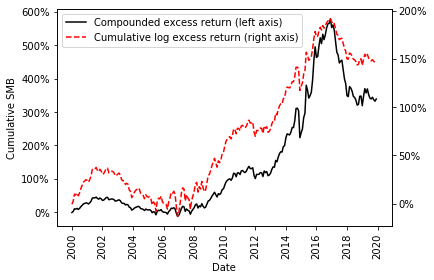

In [43]:
smbts = sizefactor()
smbts['comp'] = (smbts.smb + 1).cumprod()-1
smbts['cumlog'] = np.log((smbts.smb + 1).tolist()).cumsum()

fig = plt.figure()
ax1 = fig.add_subplot(111)
lns1=ax1.plot(smbts.comp*100, '-k', label = 'Compounded excess return (left axis)')
plt.xticks(rotation=90)
ax2 = ax1.twinx()
lns2= ax2.plot(smbts.cumlog*100, '--r', label = 'Cumulative log excess return (right axis)')
lns = lns1+lns2
plt.xticks(range(0,241,24),range(2000,2021,2))
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)
fmt='%.0f%%'
yticks = mtick.FormatStrFormatter(fmt)
ax1.yaxis.set_major_formatter(yticks)
ax2.yaxis.set_major_formatter(yticks)
ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative SMB')


![Markdown](http://i2.tiimg.com/716668/9799015acd8f1a4d.png)